In [2]:
# Comment out the two lines below to install Spark. 
#!curl -O https://d3kbcqa49mib13.cloudfront.net/spark-2.2.0-bin-hadoop2.7.tgz
#!tar -xvf spark-2.2.0-bin-hadoop2.7.tgz

#Configure your python environment by uncommenting the line below.
#!pip install findspark

import os
import findspark
os.environ["PYSPARK_PYTHON"] = "python3"
findspark.init("spark-2.2.0-bin-hadoop2.7",)

from pyspark.sql import SparkSession, Column, Row, functions as F 

spark = (
    SparkSession.builder
        .master("local[*]")
        .appName("SparkLecture577Example")
        .getOrCreate()
)
sc = spark.sparkContext

In [3]:
# Import tweets for Throwback Thursday
raw_tbt = sc.textFile("./tweets_fields_tbt.txt")
raw_tbt.take(3)

['It\'s Jay Baii\tCinnamonStixz\t923\t["RT @stevechristo_: Fun fact: Coko from SWV is featured on this but she didn\'t want to put her name on the song because Will wasn\'t a popula…"]\tYES\ten\t[]\tUNKNOWN',
 "塵太@26.28.30.1.2撮影\tJINT_athree\t150\t['@xxxxxxendless TBTに関してはタイムアタックレベルの反応なのはもはや病気なので…😇🙏\\n是非是非ーーー！ご飯いきましょ😘']\tNO\tja\t[]\tUNKNOWN",
 "Lorena V. Pinkus\tlorenavpinkus\t255\t['TBT Carnaby Street &amp; Queen #london🇬🇧 @ Carnaby London https://t.co/jEafLiDuzi']\tNO\ten\t['london']\thttps://t.co/jEafLiDuzi"]

In [4]:
# Map tweets to corresponding categories
recorded = (
    raw_tbt
        #.map(lambda x: x.lower())
        .map(lambda x: x.split("\t"))
        .map(lambda x: Row(real=x[0], user=x[1], followers = int(x[2]), text=x[3], RT=x[4], lang=x[5], hashtags=x[6], URL=x[7]))   
)

In [5]:
# Get number of tweets
recorded.count()

77957

In [6]:
# Checking how many English tweets
recorded.filter(lambda x: x['lang'] == "en").count()

50564

In [7]:
# Initially was just going include all but decided to filter just english tweets since they were the majority
# Also, adding all tweets did not change results 
only_en_tbt = (
    recorded
        .filter(lambda x: x['lang'] == "en")
)

In [8]:
import re
# Map word count while filter out unwanted text symbols and htmls
word_counts = (
    only_en_tbt
        .map(lambda x: x['text'].lower())
        .map(lambda x: x.replace("[","").replace("]","").replace("'","").replace("\\n"," ").replace("@","").replace("#","").replace(".","").replace("!","").replace("?","").replace('"',"").replace(";","").replace(":","").replace(",","").replace("é","e"))     # extract the text
        .map(lambda x: re.sub(r"https//tco/[A-z,0-9]*", " ", x))
        .flatMap(lambda x: x.split()) # split on whitespace and
                                      # convert each word into a separate record.
        .filter(lambda x: len(x) > 2) # keep words that have 3 or more letters
        .map(lambda x: (x, 1))           # Count each word 
        .reduceByKey(lambda a, b: a + b) # Sum the counts
)

In [9]:
# Map out top 10 words WITHOUT stopwords
word_counts.map(lambda x: (x[1], x[0])).top(10)

[(30390, 'the'),
 (28393, 'tbt'),
 (10577, 'this'),
 (9417, 'and'),
 (8631, 'throwbackthursday'),
 (7243, 'with'),
 (6738, 'for'),
 (5419, 'when'),
 (4830, 'was'),
 (4590, 'last')]

In [52]:
# Map out top 10 words WITH stopwords
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 
word_counts.filter(lambda x: x[0] not in STOPWORDS).map(lambda x: (x[1], x[0])).top(150)

[(28393, 'tbt'),
 (8631, 'throwbackthursday'),
 (4590, 'last'),
 (4176, 'year'),
 (4161, 'throwback'),
 (3555, 'back'),
 (3499, 'thursday'),
 (2977, 'time'),
 (2558, 'celebrating'),
 (2542, 'one'),
 (2463, 'radio'),
 (2387, 'studio'),
 (2347, 'bts'),
 (2308, 'holidays'),
 (2280, 'still'),
 (2272, 'disney'),
 (2255, 'bts_twt'),
 (2246, 'radiodisney'),
 (2245, 'bts_bighit'),
 (2076, 'years'),
 (2052, 'day'),
 (2038, '&amp'),
 (1874, 'first'),
 (1526, 'video'),
 (1316, 'ago'),
 (1275, 'love'),
 (1249, 'will'),
 (1118, 'got'),
 (1059, 'old'),
 (1056, 'show'),
 (1032, 'good'),
 (971, 'look'),
 (959, 'know'),
 (938, 'mind'),
 (917, 'game'),
 (895, 'way'),
 (871, 'big'),
 (853, 'final'),
 (848, 'night'),
 (833, 'i’m'),
 (823, 'amazing'),
 (772, 'think'),
 (769, 'week'),
 (765, 'forever'),
 (749, 'steelers'),
 (748, 'bring'),
 (739, 'two'),
 (738, 'little'),
 (736, 'new'),
 (723, 'happy'),
 (722, 'favorite'),
 (701, 'best'),
 (699, 'great'),
 (690, 'now'),
 (688, 'memories'),
 (686, 'many'),
 

In [12]:
# Get url count from official API
url_count = (
    recorded
        .map(lambda x: x['URL'])
        .map(lambda x: (x, 1))
        .reduceByKey(lambda a, b: a + b)
)

#UNKNOWN is for tweets without URLs
url_count.map(lambda x: (x[1], x[0])).top(11)

[(57135, 'UNKNOWN'),
 (252, 'https://t.co/I3PF5dyXhV'),
 (156, 'https://t.co/wxjSi0yeJp'),
 (130, 'https://t.co/GsfTxIDW2o'),
 (125, 'https://t.co/GW4ZP0Fblv'),
 (97, 'https://t.co/zQV0AiMU3c'),
 (97, 'https://t.co/s5y8ixYRE4'),
 (96, 'https://t.co/uOxCpx5a3S'),
 (73, 'https://t.co/K1VvGrpeVm'),
 (63, 'https://t.co/R0sdvHVYfc'),
 (62, 'https://t.co/NQXQFqPJ6n')]

In [13]:
# Get hashtag count from official API
hashtag_counts = (
    recorded
        .map(lambda x: x['hashtags'].lower())
        .map(lambda x: x.replace("[","").replace("]","").replace("'","").replace("\\n"," ").replace("@","").replace("#","").replace(".","").replace("!","").replace("?","").replace('"',"").replace(";","").replace(":","").replace(",","").replace("é","e"))     # extract the text
        .flatMap(lambda x: x.split()) # split on whitespace and
                                      # convert each word into a separate record.
        #.filter(lambda x: len(x) > 2) # keep words that have 3 or more letters
        .map(lambda x: (x, 1))           # Count each word 
        .reduceByKey(lambda a, b: a + b) # Sum the counts
)
hashtag_counts.map(lambda x: (x[1], x[0])).top(10)

[(42767, 'tbt'),
 (10433, 'throwbackthursday'),
 (2345, 'bts'),
 (518, 'xfactor'),
 (419, 'throwback'),
 (365, 'thursdaythoughts'),
 (320, 'ocs'),
 (320, 'gimp'),
 (320, 'ctchrysler'),
 (317, 'probowlvote')]

In [14]:
# Get top users based on follower count
recorded.map(lambda x: (x['followers'], x['user'])).top(15)

[(24172082, 'NFL'),
 (24171735, 'NFL'),
 (18615557, 'premierleague'),
 (17163697, 'ParisHilton'),
 (11543028, 'Ludacris'),
 (11542980, 'Ludacris'),
 (11542971, 'Ludacris'),
 (11542950, 'Ludacris'),
 (7937648, 'IAMQUEENLATIFAH'),
 (5950720, 'IvankaTrump'),
 (5905729, 'warriors'),
 (5398962, 'Flamengo'),
 (5269994, 'OzzyOsbourne'),
 (5266261, 'official_flo'),
 (5244834, 'TherealTaraji')]

In [16]:
# Get retweet count based on if tweet was retweet or not
RT_count = (
    only_en_tbt
        .filter(lambda x: x['RT'] == "YES")
        .map(lambda x: x['text'])
        .map(lambda x: (x, 1))
        .reduceByKey(lambda a, b: a + b)
)
RT_count.map(lambda x: (x[1], x[0])).top(10)

[(2243,
  "['RT @radiodisney: #TBT to #BTS celebrating the Holidays with us in the Radio Disney studio last year! @BTS_twt @bts_bighit https://t.co/I8RP…']"),
 (619,
  '["RT @OlisaOsega: Since it\'s a Throwback Thursday, lemme bring back this forever funny Nollywood video. 😂😭 https://t.co/gPnYS3PFs4"]'),
 (587,
  "['RT @steelers: Mind. Still. Blown. \\U0001f92f #tbt https://t.co/d1xDm5ffuU']"),
 (503,
  "['RT @TheXFactor: #ThrowbackThursday to this time last year when @Louis_Tomlinson performed this banger at The #XFactor Final! 🙌💕 https://t.c…']"),
 (501,
  "['RT @SLAMonline: literally NOTHING got in the way of the Russ and Cam Show 😂 #TBT https://t.co/EWCxm342nV']"),
 (468,
  "['RT @NBATV: When @DwyaneWade connected with @KingJames on a full-court pass! 😱\\n\\n#TBT https://t.co/EE0xkXagIe']"),
 (464,
  "['RT @HeffronDrive: “9 Years”\\n\\nSo I know I’m 1 day late, but it is #tbt so I think this still counts.\\nThere are so many amazing memories that…']"),
 (385,
  '["RT @famouslos32: 

In [53]:
# Prep for converting tweets into dataframe for word cloud
word_counts_alt = (
    only_en_tbt
        .map(lambda x: x['text'].lower())
        .map(lambda x: x.replace("[","").replace("]","").replace("'","").replace("\\n"," ").replace("@","").replace("#","").replace(".","").replace("!","").replace("?","").replace('"',"").replace(";","").replace(":","").replace(",","").replace("é","e").replace("_"," ").replace("https",""))     # extract the text
        .map(lambda x: re.sub(r"https//tco/[A-z,0-9]*", " ", x))
        .map(lambda x: Row(text = x))
)

import pandas as pd
df = word_counts_alt.toDF()
pandas_df = df.toPandas()

In [18]:
#Confirm text is converted properly
pandas_df.head()
pandas_df['text'][0:5]

0    rt stevechristo  fun fact coko from swv is fea...
1    tbt carnaby street &amp queen london🇬🇧  carnab...
2    rt rebeccalords 🆕throwbackthursday pic 🆕site l...
3    rt mariahforward despite the fact that the fda...
4    rt support uga tbt to d’andre swift’s 64 yard ...
Name: text, dtype: object

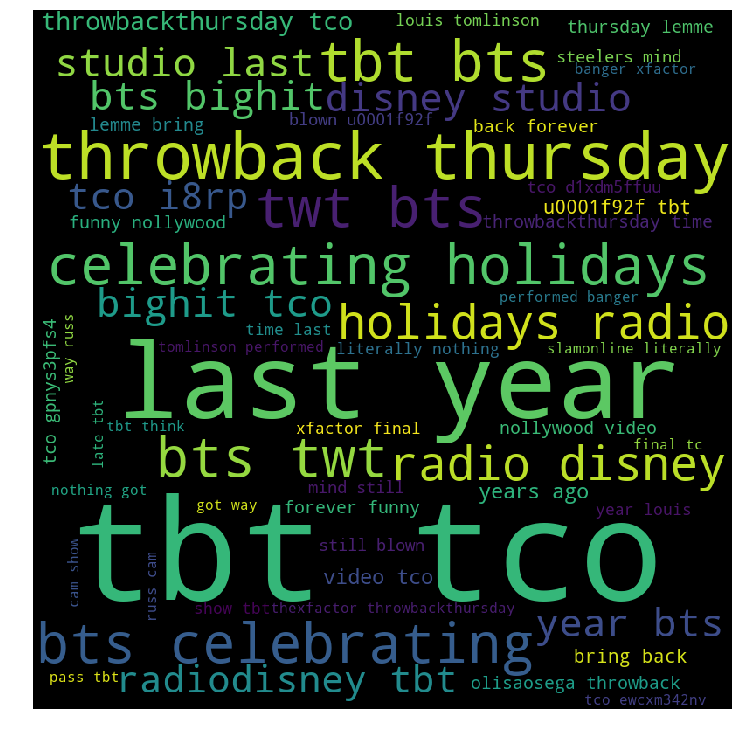

In [55]:
#Note that length of words considered is >2 so small words like rt will not be in word could
import matplotlib.pyplot as plt

comment_words = ' '
stopwords = set(STOPWORDS) 

#iterate through the CONTENT column
for val in pandas_df['text']: 
    for words in str(val).split(): 
        if len(words) > 2:
            comment_words = comment_words + words.lower() + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, background_color ='black', stopwords = stopwords, min_font_size = 15).generate(comment_words) 
  
# plot wordcloud image                      
plt.figure(figsize = (10, 10), facecolor = 'white') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

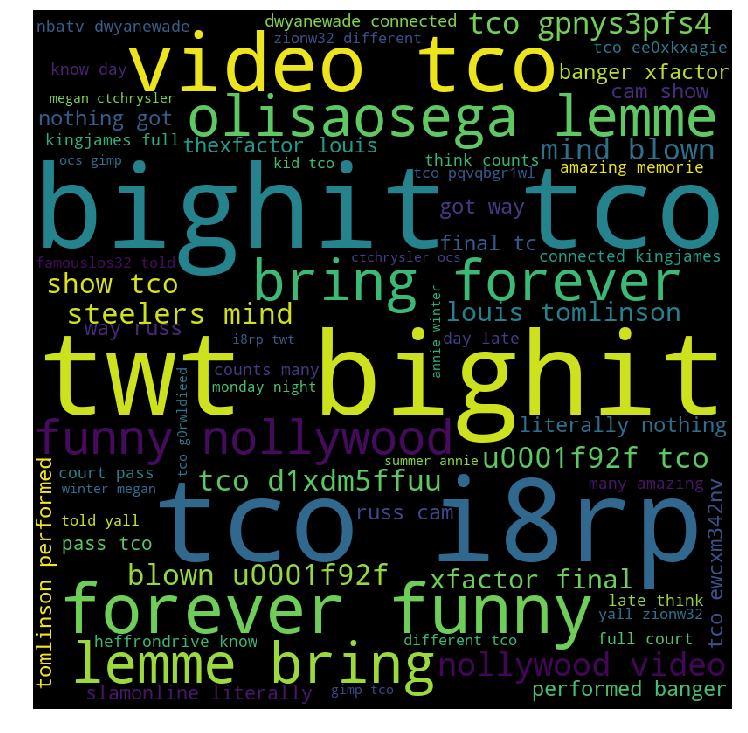

In [54]:
#Create another wordcloud with the top 20 words filtered out but it doesn't look better
# Also, even though I filtered https it still shows up
top_words = (
    word_counts
        .filter(lambda x: x[0] not in STOPWORDS)
        .map(lambda x: (x[1], x[0])).top(20)
)

#Note that length of words considered is >2 so small words like rt will not be in word could
import matplotlib.pyplot as plt
Better_STOP = set([row[1] for row in top_words] + list(STOPWORDS))
comment_words = ' '

for val in pandas_df['text']: 
    for words in str(val).split(): 
        if len(words) > 2:
            comment_words = comment_words + words.lower() + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, background_color ='black', stopwords = Better_STOP, min_font_size = 15).generate(comment_words) 
  
# plot wordcloud image                      
plt.figure(figsize = (10, 10), facecolor = 'white') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


In [219]:
# Import Pokemon Tweets
raw_lines = sc.textFile("./tweets_fields.txt")
#raw_lines = raw_lines.take(4)

In [220]:
raw_lines.take(3)

["⭐️⭐️⭐️ CGI 3D  ⭐️⭐️⭐️\tWssa25159694\t119\t['RT @DeviantArt: Happy #SmashDay, one and all. Who’s your main?\\n\\n“Pikachu and Samus” by @Rossdraws : https://t.co/mdtjK3eMWR \\n@Nintendo #Sma…']\tYES\ten\t['SmashDay']\thttps://t.co/mdtjK3eMWR",
 'julian 🇵🇭\tnice_bakuretsu\t15\t[\'RT @ClementJ64: "Of all the ridiculous things you\\\'ve told me, now you\\\'re saying you fought Super Mario, Donkey Kong, and Pikachu in Outer s…\']\tYES\ten\t[]\tUNKNOWN',
 "Phoenix Gaige\tHeartz_Exodus\t44\t['RT @adorablush: Remember to wash behind your feathers 🐣 #Pokemon #PokemonArt #birb https://t.co/3eEGCgkVnt']\tYES\ten\t['Pokemon', 'PokemonArt', 'birb']\tUNKNOWN"]

In [221]:
records = (
    raw_lines
        #.map(lambda x: x.lower())
        .map(lambda x: x.split("\t"))
        .map(lambda x: Row(real=x[0], user=x[1], followers = int(x[2]), text=x[3], RT=x[4], lang=x[5], hashtags=x[6], URL=x[7]))   
)

In [222]:
records.count()

44995

In [223]:
records.filter(lambda x: x['lang'] == "en").count()

26775

In [246]:
# For filtering english tweets but was not used
only_en = (
    records
        .filter(lambda x: x['lang'] == "en")
)

In [224]:
word_counts = (
    records
        .map(lambda x: x['text'].lower())
        .map(lambda x: x.replace("[","").replace("]","").replace("'","").replace("\\n"," ").replace("@","").replace("#","").replace(".","").replace("!","").replace("?","").replace('"',"").replace(";","").replace(":","").replace(",","").replace("é","e"))     # extract the text
        .map(lambda x: re.sub(r"https//tco/[A-z,0-9]*", " ", x))
        .flatMap(lambda x: x.split()) # split on whitespace and
                                      # convert each word into a separate record.
        .filter(lambda x: len(x) > 2) # keep words that have 3 or more letters
        .map(lambda x: (x, 1))           # Count each word 
        .reduceByKey(lambda a, b: a + b) # Sum the counts
)

In [225]:
# Get top words
word_counts.map(lambda x: (x[1], x[0])).top(50)

[(23323, 'pokemon'),
 (9769, 'the'),
 (8944, 'pikachu'),
 (6631, 'and'),
 (4397, 'eevee'),
 (4188, 'for'),
 (4086, 'pokemonletsgo'),
 (3754, 'you'),
 (3298, 'lets'),
 (3218, 'estrena'),
 (3125, 'ピカブイ'),
 (2762, 'nintendoswitch'),
 (2600, 'this'),
 (2369, 'youtube'),
 (2269, 'poke_times'),
 (2167, 'like'),
 (2097, 'que'),
 (2068, 'with'),
 (1952, 'that'),
 (1912, 'one'),
 (1879, 'your'),
 (1877, 'video'),
 (1767, 'catch'),
 (1668, 'all'),
 (1559, 'but'),
 (1534, 'are'),
 (1503, 'can'),
 (1488, 'team'),
 (1457, 'make'),
 (1448, 'ready'),
 (1423, 'shiny'),
 (1391, '発売記念'),
 (1391, '151プレゼントキャンペーン🎉'),
 (1209, 'way'),
 (1180, 'have'),
 (1163, 'grab'),
 (1139, 'sonic_hedgehog'),
 (1133, 'new'),
 (1132, 'por'),
 (1132, 'first'),
 (1115, 'was'),
 (1115, 'some'),
 (1106, 'life'),
 (1067, 'more'),
 (1025, 'how'),
 (1020, 'blue'),
 (1017, 'now'),
 (1001, 'stop'),
 (988, '&amp'),
 (979, 'quick')]

In [227]:
from wordcloud import WordCloud, STOPWORDS 

In [228]:
word_counts.filter(lambda x: x[0] not in STOPWORDS).map(lambda x: (x[1], x[0])).top(50)

[(23323, 'pokemon'),
 (8944, 'pikachu'),
 (4397, 'eevee'),
 (4086, 'pokemonletsgo'),
 (3298, 'lets'),
 (3218, 'estrena'),
 (3125, 'ピカブイ'),
 (2762, 'nintendoswitch'),
 (2369, 'youtube'),
 (2269, 'poke_times'),
 (2097, 'que'),
 (1912, 'one'),
 (1877, 'video'),
 (1767, 'catch'),
 (1488, 'team'),
 (1457, 'make'),
 (1448, 'ready'),
 (1423, 'shiny'),
 (1391, '発売記念'),
 (1391, '151プレゼントキャンペーン🎉'),
 (1209, 'way'),
 (1163, 'grab'),
 (1139, 'sonic_hedgehog'),
 (1133, 'new'),
 (1132, 'por'),
 (1132, 'first'),
 (1106, 'life'),
 (1020, 'blue'),
 (1017, 'now'),
 (1001, 'stop'),
 (988, '&amp'),
 (979, 'quick'),
 (977, 'last'),
 (967, 'mind'),
 (935, 'avengers'),
 (935, 'along'),
 (934, 'giveaway'),
 (880, 'switch'),
 (880, 'story'),
 (878, 'game'),
 (867, 'toy'),
 (855, 'marvel'),
 (851, 'hyliagames'),
 (846, 'nintendo'),
 (838, 'think'),
 (837, 'endgame'),
 (830, 'still'),
 (821, 'versión'),
 (815, 'con'),
 (806, '抽選で151名様に')]

In [229]:
# Get top pokemons
pokemons = set(line.lower().strip() for line in open('pokemon_names.txt'))
type(pokemons)

set

In [231]:
word_counts.filter(lambda x: x[0] in pokemons).map(lambda x: (x[1], x[0])).top(20)

[(8944, 'pikachu'),
 (4397, 'eevee'),
 (412, 'bulbasaur'),
 (275, 'butterfree'),
 (161, 'mewtwo'),
 (144, 'golbat'),
 (144, 'clefairy'),
 (126, 'sandshrew'),
 (102, 'charizard'),
 (98, 'charmander'),
 (89, 'gengar'),
 (87, 'lucario'),
 (79, 'salazzle'),
 (78, 'incineroar'),
 (73, 'pichu'),
 (66, 'nidoking'),
 (64, 'squirtle'),
 (63, 'mankey'),
 (62, 'vulpix'),
 (62, 'mew')]

In [232]:
# Get top url
url_count = (
    records
        .map(lambda x: x['URL'])
        .map(lambda x: (x, 1))
        .reduceByKey(lambda a, b: a + b)
)

In [234]:
# Get top URLs
url_count.map(lambda x: (x[1], x[0])).top(11)

[(30690, 'UNKNOWN'),
 (918, 'https://t.co/XsFziw9BzH'),
 (707, 'https://t.co/6pHZLnXE6H'),
 (348, 'https://t.co/AVsytuA0t0'),
 (205, 'https://t.co/001IV3OeeK'),
 (144, 'https://t.co/irGgOvnaL7'),
 (117, 'https://t.co/7cDRMw8mrM'),
 (105, 'https://t.co/oElhwzUF1s'),
 (79, 'https://t.co/IxbvkMLqWr'),
 (69, 'https://t.co/wLPIc8Rxv3'),
 (51, 'https://t.co/04UWQWHTz8')]

In [236]:
# Get top users
records.map(lambda x: (x['followers'], x['user'])).top(30)

[(14832021, 'detikcom'),
 (5706796, 'sonic_hedgehog'),
 (5145921, 'Pokemon'),
 (4854624, 'El_Universal_Mx'),
 (4009794, 'VIVAcoid'),
 (3399152, 'liputan6dotcom'),
 (3357666, 'DolarToday'),
 (3156793, 'noticias24'),
 (2416601, 'gameinformer'),
 (2416561, 'gameinformer'),
 (2386998, 'engadget'),
 (2278137, 'Esp_Interativo'),
 (1910569, 'BBC_TopGear'),
 (1768493, 'UniNoticias'),
 (1729415, 'RPPNoticias'),
 (1595995, 'FrasesVersos'),
 (1284857, 'sternde'),
 (1122028, 'CaraotaDigital'),
 (849426, 'NoticiasVenezue'),
 (740296, 'lancenet'),
 (740294, 'lancenet'),
 (534943, 'gizmodojapan'),
 (512927, 'maudado'),
 (495404, 'Forbes_Mexico'),
 (479693, 'periodicovzlano'),
 (430951, 'NintendoUK'),
 (417800, 'MyNintendoNews'),
 (417704, 'MyNintendoNews'),
 (413021, 'ringer'),
 (380102, 'VideojuegosGAME')]

In [61]:
records.filter(lambda x: x['user'] == "BBC_TopGear").take(1)

[Row(RT='NO', URL='https://t.co/CxtXO3CVV2', followers=1910569, hashtags='[]', lang='en', real='Top Gear', text="['Gaming: Gear Club Unlimited 2 is Pokemon for petrolheads. Nintendo Switch racer offers compelling car collection bu… https://t.co/CxtXO3CVV2']", user='BBC_TopGear')]

In [237]:
hashtag_counts = (
    records
        .map(lambda x: x['hashtags'].lower())
        .map(lambda x: x.replace("[","").replace("]","").replace("'","").replace("\\n"," ").replace("@","").replace("#","").replace(".","").replace("!","").replace("?","").replace('"',"").replace(";","").replace(":","").replace(",","").replace("é","e"))     # extract the text
        .flatMap(lambda x: x.split()) # split on whitespace and
                                      # convert each word into a separate record.
        .map(lambda x: (x, 1))           # Count each word 
        .reduceByKey(lambda a, b: a + b) # Sum the counts
)

In [238]:
# Get top hashtags
hashtag_counts.map(lambda x: (x[1], x[0])).top(20)

[(4158, 'pokemonletsgo'),
 (3338, 'pokemon'),
 (3126, 'ピカブイ'),
 (2776, 'nintendoswitch'),
 (707, 'ポケモンtagteamストーリー'),
 (566, 'pokemongo'),
 (404, 'ポケモン'),
 (332, 'pikachu'),
 (197, 'eevee'),
 (176, 'sonicmovie'),
 (154, 'nintendo'),
 (151, 'ぷろじぇくといーぶいだよ'),
 (105, 'ピカチュウ'),
 (105, 'ebay'),
 (104, 'smashbrosultimate'),
 (93, 'twitch'),
 (89, 'smashbros'),
 (87, 'aldubjusthappier'),
 (82, 'nsfw'),
 (78, 'teameevee')]

In [239]:
RT_count = (
    records
        .filter(lambda x: x['RT'] == "YES")
        .map(lambda x: x['text'])
        .map(lambda x: (x, 1))
        .reduceByKey(lambda a, b: a + b)
)
RT_count.map(lambda x: (x[1], x[0])).top(20)

[(918,
  "['RT @sonic_hedgehog: Blue Team for life.\\n\\nMind if we make one quick stop along the way to grab Pikachu? @Pokemon https://t.co/XsFziw9BzH']"),
 (806,
  "['RT @poke_times: ／\\n#ピカブイ 発売記念\\n151プレゼントキャンペーン🎉\\n＼\\n@poke_timesをフォロー➕この投稿をRT🔄\\n抽選で151名様に #ピカブイ に登場するポケモン151匹のぬいぐるみをランダムでプレゼント🎁\\n\\n#ピカブイ で一緒に冒険したポケモ…']"),
 (803,
  "['RT @InvictosSomos: ➔ Se estrena Avengers: Endgame. \\n➔ Se estrena Capitana Marvel. \\n➔ Se estrena Toy Story 4. \\n➔ Se estrena la versión Live…']"),
 (707,
  "['RT @poke_times: ～カードの数だけ 出会いがある～\\n\\n友達を作りたかった、ミミッキュとゲンガーの話。\\n\\n#ポケモンTAGTEAMストーリー\\nhttps://t.co/6pHZLnXE6H https://t.co/Qir3ggp4Dr']"),
 (605,
  "['RT @Pokemon: Risa’s ready to catch her first Eevee…but is Eevee ready to be caught? 🤔 \\n\\nTomorrow’s your last chance to catch #PokemonThePow…']"),
 (585,
  "['RT @poke_times: ／\\n#ピカブイ 発売記念\\n151プレゼントキャンペーン🎉\\n＼\\n\\nPokémon fitのぬいぐるみ151種類が、ランダムで当たるかも😲!?\\nあなたの元にやってくるポケモンはどのポケモンでしょう💭\\n\\n✔@poke_timesをフォロー\\n✔このツイー…']"),
 (514,
  "['RT @Br

In [240]:
word_counts_poke = (
    records
        .map(lambda x: x['text'].lower())
        .map(lambda x: x.replace("[","").replace("]","").replace("'","").replace("\\n"," ").replace("@","").replace("#","").replace(".","").replace("!","").replace("?","").replace('"',"").replace(";","").replace(":","").replace(",","").replace("é","e").replace("_"," "))     # extract the text
        .map(lambda x: re.sub(r"https//tco/[A-z,0-9]*", " ", x))
        .map(lambda x: Row(text = x))
)

#word_counts_alt.take(3)

import pandas as pd
df = word_counts_poke.toDF()
pandas_df = df.toPandas()

In [241]:
import numpy as np
from PIL import Image
mask = np.array(Image.open("./pokeball.png"))

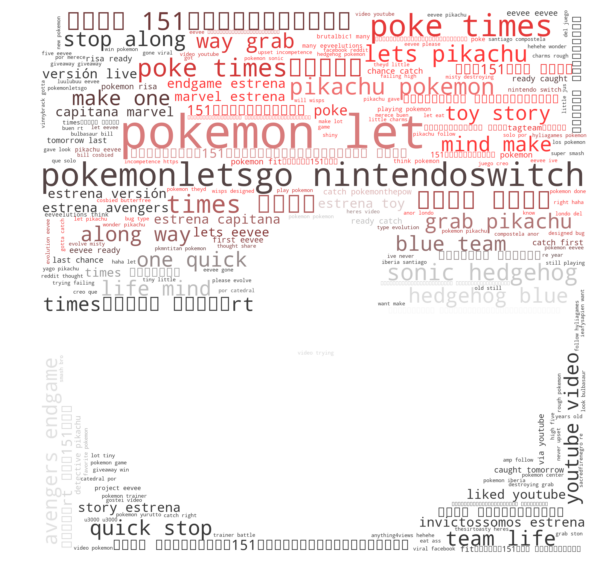

In [243]:
import matplotlib.pyplot as plt
from wordcloud import ImageColorGenerator

comment_words = ' '
stopwords = set(STOPWORDS) 

#iterate through the CONTENT column
for val in pandas_df['text']: 
    for words in str(val).split(): 
        if len(words) > 2:
            comment_words = comment_words + words.lower() + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', mode="RGBA", mask=mask, stopwords = stopwords, min_font_size=15).generate(comment_words) 
image_colors = ImageColorGenerator(mask)


    
# plot wordcloud image                      
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
#plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show() 

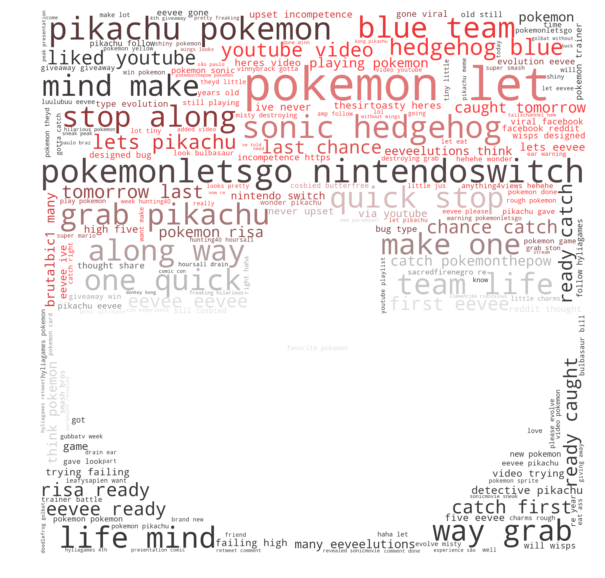

In [247]:
# Japanese words don't render with wordcloud, so filter them out
word_counts_poke = (
    only_en
        .map(lambda x: x['text'].lower())
        .map(lambda x: x.replace("[","").replace("]","").replace("'","").replace("\\n"," ").replace("@","").replace("#","").replace(".","").replace("!","").replace("?","").replace('"',"").replace(";","").replace(":","").replace(",","").replace("é","e").replace("_"," "))     # extract the text
        .map(lambda x: re.sub(r"https//tco/[A-z,0-9]*", " ", x))
        .map(lambda x: Row(text = x))
)

#word_counts_alt.take(3)

df = word_counts_poke.toDF()
pandas_df = df.toPandas()
mask = np.array(Image.open("./pokeball.png"))
comment_words = ' '
stopwords = set(STOPWORDS) 

#iterate through the CONTENT column
for val in pandas_df['text']: 
    for words in str(val).split(): 
        if len(words) > 2:
            comment_words = comment_words + words.lower() + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', mode="RGBA", mask=mask, stopwords = stopwords, min_font_size=15).generate(comment_words) 
image_colors = ImageColorGenerator(mask)


    
# plot wordcloud image                      
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
#plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show() 

In [118]:
# Filtering out japanese text only
only_jp = (
    records
        .filter(lambda x: x['lang'] == "ja")
)

In [126]:
only_jp.take(3)

[Row(RT='NO', URL='https://t.co/JWO0baq9Sf', followers=2875, hashtags="['Pokemon', 'ポケモン', 'ポケットモンスター', 'ピカブイ']", lang='ja', real='すずきたかまさのポケモン攻略', text='["【ポケットモンスター Let\'s GO！ ピカチュウ・Let\'s GO！ イーブイ】攻略！色違いを集めてみたり、厳選準備してみたり...\\nhttps://t.co/JWO0baq9Sf\\n#Pokemon #ポケモン #ポケットモンスター #ピカブイ"]', user='8131games'),
 Row(RT='YES', URL='UNKNOWN', followers=295, hashtags='[]', lang='ja', real='Khai Raccoon', text="['RT @poke_times: 「りかけいのおとこ」は、『ポケットモンスター』シリーズに登場するポケモントレーナー\\n「ロボピカチュウ」は、『ポケモン ハートゴールド・ソウルシルバー』に登場するりかけいのおとこが連れているロボットなのです🔧⚙\\n\\nhttps://t.co/GTUr…']", user='RaccoonKhai'),
 Row(RT='YES', URL='https://t.co/wLPIc8Rxv3', followers=71, hashtags="['名探偵ピカチュウ', 'ピカチュウ']", lang='ja', real='昭 モブサイ二期が楽しみ', text="['RT @meitantei_pika: 🎬「#名探偵ピカチュウ」プロモ映像解禁!🔍\\n見た目はカワイイけど…中身は“おっさん”!?😱\\n※しかもしゃべる!?\\nまだ誰も見たことのない #ピカチュウ の物語がここに誕生。✨\\nhttps://t.co/wLPIc8Rxv3 https:/…']", user='1059_akira')]

In [138]:
word_counts_jp = (
    only_jp
        .map(lambda x: x['text'])
        .map(lambda x: x.replace("[","").replace("]","").replace("'","").replace("\\n"," ").replace("@","").replace("#","").replace(".","").replace("!","").replace("?","").replace('"',"").replace(";","").replace(":","").replace(",","").replace("é","e"))     # extract the text
        .map(lambda x: Row(text = x))
)

In [139]:
word_counts_jp.take(3)

[Row(text='【ポケットモンスター Lets GO！ ピカチュウ・Lets GO！ イーブイ】攻略！色違いを集めてみたり、厳選準備してみたり https//tco/JWO0baq9Sf Pokemon ポケモン ポケットモンスター ピカブイ'),
 Row(text='RT poke_times 「りかけいのおとこ」は、『ポケットモンスター』シリーズに登場するポケモントレーナー 「ロボピカチュウ」は、『ポケモン ハートゴールド・ソウルシルバー』に登場するりかけいのおとこが連れているロボットなのです🔧⚙  https//tco/GTUr…'),
 Row(text='RT meitantei_pika 🎬「名探偵ピカチュウ」プロモ映像解禁🔍 見た目はカワイイけど…中身は“おっさん”😱 ※しかもしゃべる まだ誰も見たことのない ピカチュウ の物語がここに誕生。✨ https//tco/wLPIc8Rxv3 https/…')]

In [140]:
import pandas as pd
df = word_counts_jp.toDF()
pandas_df = df.toPandas()
pandas_df.head()

,text
0,【ポケットモンスター Lets GO！ ピカチュウ・Lets GO！ イーブイ】攻略！色違い...
1,RT poke_times 「りかけいのおとこ」は、『ポケットモンスター』シリーズに登場する...
2,RT meitantei_pika 🎬「名探偵ピカチュウ」プロモ映像解禁🔍 見た目はカワイイ...
3,RT lyc_alma ゼラオラを描きました zeraora pokemon ポケモン ht...
4,これもう発売されているのかな？( ੭˙꒳ ˙)੭


In [144]:
pandas_df.to_csv(path_or_buf="./jp_text.txt")
#Rest is done in R because mecab installation to python doesn't work and manually doing text in terminal is not my expertise

In [81]:
test[0]

"⭐️⭐️⭐️ CGI 3D  ⭐️⭐️⭐️\tWssa25159694\t119\t['RT @DeviantArt: Happy #SmashDay, one and all. Who’s your main?\\n\\n“Pikachu and Samus” by @Rossdraws : https://t.co/mdtjK3eMWR \\n@Nintendo #Sma…']\tYES\ten\t['SmashDay']\thttps://t.co/mdtjK3eMWR"

In [82]:
testo = test[0].split("\t")

In [83]:
testo

['⭐️⭐️⭐️ CGI 3D  ⭐️⭐️⭐️',
 'Wssa25159694',
 '119',
 "['RT @DeviantArt: Happy #SmashDay, one and all. Who’s your main?\\n\\n“Pikachu and Samus” by @Rossdraws : https://t.co/mdtjK3eMWR \\n@Nintendo #Sma…']",
 'YES',
 'en',
 "['SmashDay']",
 'https://t.co/mdtjK3eMWR']

In [85]:
test[0].split("\t")[5]

'en'

In [64]:
test0 = testo[1].replace("[","").replace("]","").replace("'","")

In [65]:
test0


'SmashDay'

In [62]:
test0.split(",")

['SmashDay']